In [15]:
from quantrocket.history import create_usstock_db, collect_history
from quantrocket.master import get_securities
from quantrocket.history import download_history_file
import pandas as pd

In [ ]:
# Step 1: Create a US stock database named "aapl-2023" with daily bars and mark it as a free database
create_usstock_db("aapl", bar_size="1 day", free=True)

In [8]:
# Step 2: Collect historical data for the created database
collect_history("aapl")

{'status': 'the historical data will be collected asynchronously'}

In [9]:
# Step 3: Obtain the unique identifier (sid) for Apple stock (AAPL)
securities = get_securities(vendors="usstock", sec_types="STK")
aapl_sid = securities.loc[securities["Symbol"] == "AAPL"].index[0]

In [10]:
from quantrocket import get_prices
# Step 4: Retrieve the historical price data for Apple stock (AAPL) as a DataFrame
price_data = get_prices("aapl", sids=[aapl_sid], start_date="2023-01-01", end_date="2023-12-31", fields=["Close"])

# Step 5: Save the DataFrame to a CSV file
csv_file_path = "aapl_data.csv"
price_data.to_csv(csv_file_path)

In [11]:
data = pd.read_csv("aapl_data.csv")
data

,Field,Date,FIBBG000B9XRY4
0,Close,2023-01-03,124.2163
1,Close,2023-01-04,125.4975
2,Close,2023-01-05,124.1666
3,Close,2023-01-06,128.7352
4,Close,2023-01-09,129.2616
...,...,...,...
245,Close,2023-12-22,193.3533
246,Close,2023-12-26,192.8040
247,Close,2023-12-27,192.9038
248,Close,2023-12-28,193.3333


In [41]:
# Define the new column names
new_column_names = {'Field': 'Field',
                    'Date': 'Date',
                    'FIBBG000B9XRY4': 'Price'}

# Rename the columns
data = data.rename(columns=new_column_names)

In [42]:
data = pd.DataFrame(data)
data

,Field,Date,Price
0,Close,2023-01-03,124.2163
1,Close,2023-01-04,125.4975
2,Close,2023-01-05,124.1666
3,Close,2023-01-06,128.7352
4,Close,2023-01-09,129.2616
...,...,...,...
245,Close,2023-12-22,193.3533
246,Close,2023-12-26,192.8040
247,Close,2023-12-27,192.9038
248,Close,2023-12-28,193.3333


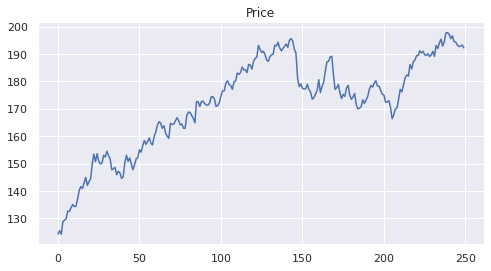

In [43]:
# @title Price

from matplotlib import pyplot as plt
data['Price'].plot(kind='line', figsize=(8, 4), title='Price')
plt.gca().spines[['top', 'right']].set_visible(False)

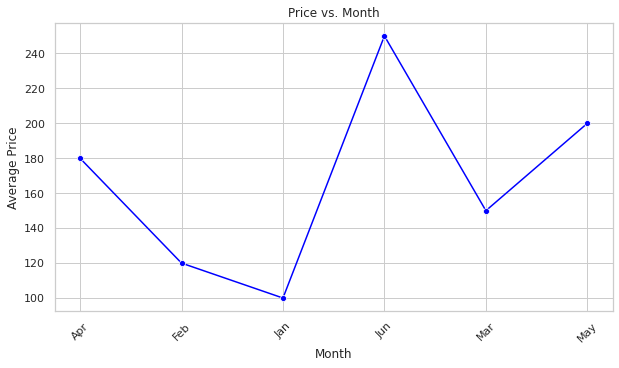

In [54]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Create some example data
d = {'month': ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun'],
       'price': [100, 120, 150, 180, 200, 250]}

df = pd.DataFrame(d)

# Group the data by month
grouped_data = df.groupby('month')['price'].mean().reset_index()  # Reset index to make month a column

# Set Seaborn style
sns.set_style("whitegrid")

# Create a line plot using Seaborn
plt.figure(figsize=(10, 5.2))
sns.lineplot(data=grouped_data, x='month', y='price', marker='o', color='blue')

# Add labels and title
plt.xlabel('Month')
plt.ylabel('Average Price')
plt.title('Price vs. Month')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.show()


In [46]:
import numpy as np

class QLearningAgent:
    def __init__(self, n_states, n_actions, learning_rate=0.1, discount_factor=0.9, epsilon=0.1):
        self.q_table = np.zeros((n_states, n_actions))
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.epsilon = epsilon
        self.prev_state = None
        self.prev_action = None

    def select_action(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.randint(len(self.q_table[state]))
        else:
            return np.argmax(self.q_table[state])

    def update_q_table(self, state, action, reward, next_state):
        if self.prev_state is not None and self.prev_action is not None:
            old_value = self.q_table[self.prev_state, self.prev_action]
            next_max = np.max(self.q_table[next_state])
            new_value = old_value + self.learning_rate * (reward + self.discount_factor * next_max - old_value)
            self.q_table[self.prev_state, self.prev_action] = new_value

        self.prev_state = state
        self.prev_action = action

    def reset(self):
        self.prev_state = None
        self.prev_action = None

def calculate_state(returns):
    if returns >= 0.1:
        return 2  # Bull state
    elif returns > -0.1:
        return 1  # Flat state
    else:
        return 0  # Bear state

def preprocess_data(data):
    # Assuming 'Field' and 'Date' are not relevant for modeling, we'll drop them
    processed_data = data.drop(['Field', 'Date'], axis=1)
    return processed_data


In [47]:
#main function
def main(data, agent, epochs=100):
    portfolio_value = 0

    for epoch in range(epochs):
        portfolio_value = 0
        agent.reset()

        for i in range(len(data) - 1): 
            current_price = float(data.iloc[i].iloc[0]) 
            next_price = float(data.iloc[i + 1].iloc[0])
            returns = (next_price - current_price) / current_price
            #print(type(returns))
            state = calculate_state(returns)
            action = agent.select_action(state)

            # Execute action (place buy order)
            if action == 1:
                portfolio_value += 1
            elif action == 2:
                portfolio_value -= 1

            # Update Q-table
            next_returns = (data.iloc[i+1].iloc[0] - data.iloc[i].iloc[0]) / data.iloc[i].iloc[0]
            next_state = calculate_state(next_returns)
            reward = 1 if action == 1 and next_state == 2 else -1 if action == 2 and next_state == 0 else 0
            agent.update_q_table(state, action, reward, next_state)

    return portfolio_value

In [48]:
processed_data = preprocess_data(data)
n_states = 3  # Number of states (Bull, Flat, Bear)
n_actions = 3  # Number of actions (Hold, Buy, Sell)
agent = QLearningAgent(n_states, n_actions)

In [49]:
print(processed_data)

        Price
0    124.2163
1    125.4975
2    124.1666
3    128.7352
4    129.2616
..        ...
245  193.3533
246  192.8040
247  192.9038
248  193.3333
249  192.2846

[250 rows x 1 columns]


In [50]:
portfolio_value = main(processed_data, agent)
print("Portfolio Value: ", portfolio_value)

Portfolio Value:  -3
